In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import math
from keras.utils import plot_model

np.random.seed(10)

In [19]:
df = pd.read_csv('./Data/mergedFiles.csv', usecols=[1])
dataset   = df.values
dataset   = dataset.astype('float32')
df.head()

,Byron Bay (Belongil Creek)
0,2.75
1,0.25
2,6.50
3,7.00
4,0.00


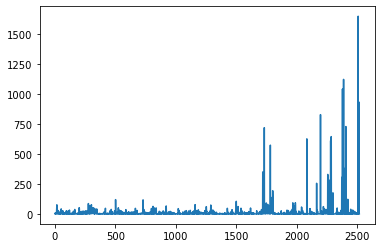

In [20]:
plt.plot(dataset)

In [21]:
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [22]:
train_size  = int(len(dataset) * 0.)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(len(train), len(test))

1688 832


In [23]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [25]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(2520, n_features)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1677/1677 - 4s - loss: 5.8704e-05 - 4s/epoch - 3ms/step
Epoch 2/50
1677/1677 - 2s - loss: 5.1088e-05 - 2s/epoch - 1ms/step
Epoch 3/50
1677/1677 - 2s - loss: 4.6439e-05 - 2s/epoch - 1ms/step
Epoch 4/50
1677/1677 - 2s - loss: 4.3800e-05 - 2s/epoch - 1ms/step
Epoch 5/50
1677/1677 - 2s - loss: 4.3152e-05 - 2s/epoch - 1ms/step
Epoch 6/50
1677/1677 - 2s - loss: 4.1965e-05 - 2s/epoch - 1ms/step
Epoch 7/50
1677/1677 - 2s - loss: 4.2816e-05 - 2s/epoch - 1ms/step
Epoch 8/50
1677/1677 - 2s - loss: 4.0688e-05 - 2s/epoch - 1ms/step
Epoch 9/50
1677/1677 - 2s - loss: 4.0728e-05 - 2s/epoch - 1ms/step
Epoch 10/50
1677/1677 - 2s - loss: 4.0561e-05 - 2s/epoch - 1ms/step
Epoch 11/50
1677/1677 - 2s - loss: 4.0437e-05 - 2s/epoch - 1ms/step
Epoch 12/50
1677/1677 - 2s - loss: 4.0561e-05 - 2s/epoch - 1ms/step
Epoch 13/50
1677/1677 - 2s - loss: 4.0452e-05 - 2s/epoch - 1ms/step
Epoch 14/50
1677/1677 - 2s - loss: 3.9884e-05 - 2s/epoch - 1ms/step
Epoch 15/50
1677/1677 - 3s - loss: 4.0254e-05 - 3s/epoch 

In [34]:
model.save('Durrumbul_WL.h5')

In [44]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

AttributeError: 'MinMaxScaler' object has no attribute 'min_'

TypeError: float() argument must be a string or a number, not 'History'

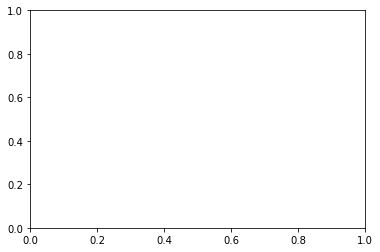

In [42]:
plt.plot(model.history)

In [48]:
newdata = pd.read_csv('./Data/mergedFiles.csv', usecols=[1])

In [71]:
newdata = newdata.drop(['LAT', 'LONG'], axis=1)

In [49]:
newdata.head()

,Byron Bay (Belongil Creek)
0,2.75
1,0.25
2,6.50
3,7.00
4,0.00


In [50]:
newdata[newdata['HT'] < 0] = 0

KeyError: 'HT'

In [51]:
new_test = newdata['HT'].values

KeyError: 'HT'

In [52]:
plt.plot(new_test[0:30000])

NameError: name 'new_test' is not defined

In [53]:
new_dataset   = newdata.values
new_dataset   = new_dataset.astype('float32')

In [54]:
unseen_clean = []
for i in new_dataset:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [80]:
newdata.info

<bound method DataFrame.info of                  Unnamed: 0  PRCP    HT
0       2005-11-26 00:00:00   0.2  1.52
1       2005-11-26 00:15:00   2.8  1.53
2       2005-11-26 00:30:00   3.8  1.52
3       2005-11-26 00:45:00   7.2  1.53
4       2005-11-26 01:00:00   9.6  1.54
...                     ...   ...   ...
689957  2025-07-31 01:15:00   0.0  0.84
689958  2025-07-31 01:30:00   0.0  0.85
689959  2025-07-31 01:45:00   0.0  0.84
689960  2025-07-31 02:00:00   0.0  0.85
689961  2025-07-31 02:15:00   0.0  0.84

[689962 rows x 3 columns]>

In [56]:
features,labels = create_dataset(unseen_clean, slide_window)
features = np.reshape(features, (2509,1, 10)) 

In [45]:
model = keras.models.load_model('./Models/LSTM.h5')

In [57]:
result = model.predict(features)

ValueError: in user code:

    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_26" is incompatible with the layer: expected shape=(None, 3, 8), found shape=(None, 1, 10)


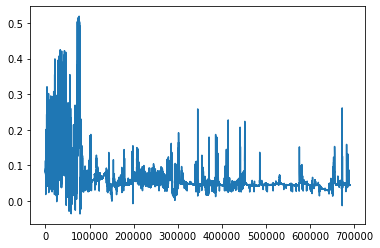

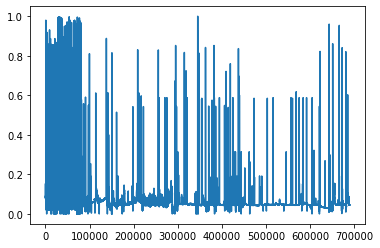

In [90]:
plt.plot(result)
plt.show()

plt.plot(labels)
plt.show()

In [92]:
testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.51 RMSE
